In [103]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Add
import os

In [54]:
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image)
    image = tf.image.resize(image, (94, 94))
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    image = tf.expand_dims(image, axis=0)

    return image

In [42]:
input_shape = (94, 94, 3)
latent_dim = 32


class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=input_shape),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((3, 3), padding='same'),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((3, 3), padding='same'),
            layers.Flatten()
        ])
        self.mean = layers.Dense(latent_dim)
        self.log_var = layers.Dense(latent_dim)
    
    def call(self, X):
        X = self.encoder(X)
        return self.mean(X), self.log_var(X)


class Decoder(Model):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(1, latent_dim)),
            layers.Dense(7 * 7 * 64, activation='relu'),
            layers.Reshape((7, 7, 64)),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')
        ])
    
    def call(self, X):
        return self.decoder(X)


class VAE(Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def call(self, X):
        mu, sigma = self.encoder(X)
        epsilon = tf.random.normal(tf.shape(mu))
        z = tf.expand_dims(mu + epsilon * sigma, axis=0)
        X_reconstructed = self.decoder(z)

        return X_reconstructed, mu, sigma
        

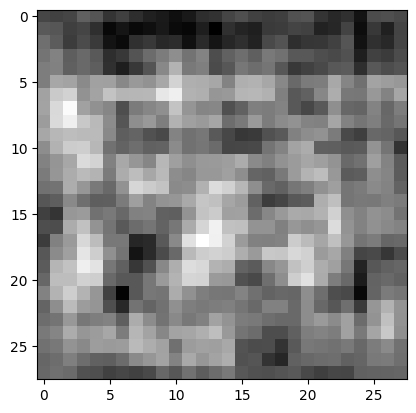

In [125]:
input_shape = (94, 94, 3)
latent_dim = 32


class VAE(Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=input_shape),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim)
        ])
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(7 * 7 * 32, activation='relu'),
            layers.Reshape((7, 7, 32)),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, X):
        mu, sigma = self.encoder(X), self.encoder(X)
        epsilon = tf.random.normal(tf.shape(sigma))
        z = mu + epsilon * tf.exp(0.5 * sigma)
        reconstruction = self.decoder(z)
        return reconstruction


path = '../data/'
images = os.listdir(path)
image = load_image(path + images[1])

latent_dim = 32

model = VAE(latent_dim)
output = (model(image)[0] * 255.0).numpy()


plt.imshow(output, cmap='gray')
plt.show()